In [ ]:
# https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4

# Learning to make Makemore by Andrej Karpathy!
# Makemore is a Character Level Language Model
# Treats every input as a sequence of individual characters
# predict next character in the sequence
# 
# Implementing: Recurrent Neural Networks

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [19]:
block_size = 3

def build_dataset(words):

    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80% training
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% validation
Xte, Yte = build_dataset(words[n2:]) # 10% test

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [111]:
# MLP Revisited
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) # lookup table

# Kaiming init for tanh nonlinearity
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # hidden layer
# b1 = torch.randn(n_hidden, generator=g) * 0.01
# scaling down to account for tanh neurons not being dead

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # output layer
b2 = torch.randn(vocab_size, generator=g) * 0
# want to initialize much smaller logits (closer to 0) 

# used for Batch Normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


tensor(0.0102) tensor(1.0077)
tensor(0.0026) tensor(0.9939)


(array([2.23092476e-05, 4.46184953e-05, 2.23092476e-05, 1.11546238e-04,
        1.56164733e-04, 2.45401724e-04, 4.68494200e-04, 5.80040438e-04,
        8.70060658e-04, 1.71781207e-03, 2.83327445e-03, 4.55108652e-03,
        6.96048526e-03, 1.24708694e-02, 1.97213749e-02, 3.11214004e-02,
        4.81879749e-02, 7.12780462e-02, 1.04541134e-01, 1.44206977e-01,
        1.91814911e-01, 2.51737550e-01, 3.14627319e-01, 3.70578912e-01,
        4.15442809e-01, 4.30970046e-01, 4.18945361e-01, 3.82915926e-01,
        3.22948669e-01, 2.59858116e-01, 1.99957787e-01, 1.44876254e-01,
        1.04474207e-01, 7.03633670e-02, 4.87457061e-02, 3.07867617e-02,
        1.88959327e-02, 1.26939619e-02, 8.61136959e-03, 5.13112696e-03,
        2.94482069e-03, 1.67319357e-03, 1.45010110e-03, 5.57731191e-04,
        1.78473981e-04, 2.67710972e-04, 1.78473981e-04, 6.69277429e-05,
        0.00000000e+00, 4.46184953e-05]),
 array([-5.72026873, -5.49614642, -5.27202412, -5.04790181, -4.82377951,
        -4.5996572 , 

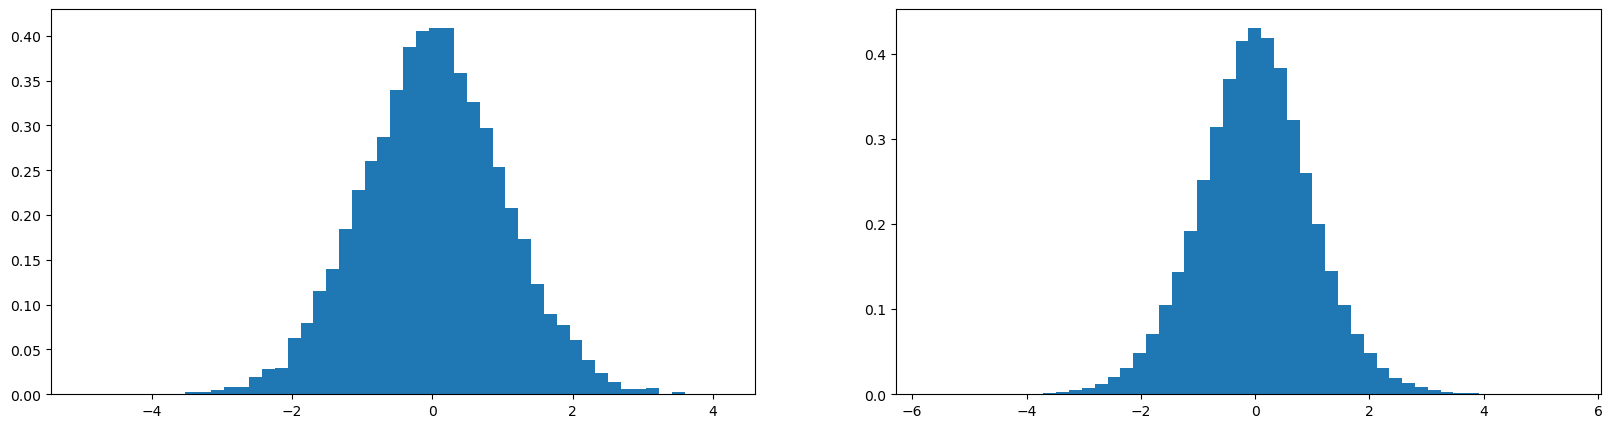

In [81]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 30**0.5 # want a std of one, divide by square root of fan_in
# inspired by Kaiming He et al paper: https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [97]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation

    # b1.grad() is 0 and is doing nothing because it is getting subtracted when doing Batch Norm

    # Batch Normalization: implementation by Ioffe and Szegedy 2015 Google Paper
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = std(0, keepdim=True)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    # every neuron on the batch are normalized to Gaussian now
    # keeping track of mean and std approximately instead of recalibrating batch norm after
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.0001 + bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000:  3.2963
  10000/ 200000:  1.6929
  20000/ 200000:  1.8320
  30000/ 200000:  2.3207
  40000/ 200000:  2.4915
  50000/ 200000:  1.7569
  60000/ 200000:  2.4385
  70000/ 200000:  2.1219
  80000/ 200000:  1.6795
  90000/ 200000:  2.1480
 100000/ 200000:  2.1768
 110000/ 200000:  2.0357
 120000/ 200000:  1.7839
 130000/ 200000:  1.7549
 140000/ 200000:  2.1074
 150000/ 200000:  2.1052
 160000/ 200000:  1.7375
 170000/ 200000:  2.0859
 180000/ 200000:  2.5050
 190000/ 200000:  1.7592
2.1322929859161377


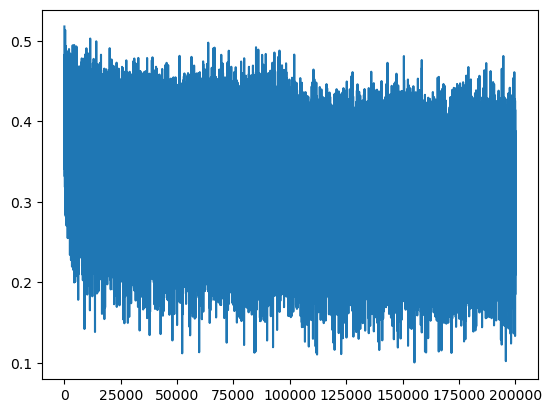

In [98]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training
# no longer needed with running implementation

with torch.no_grad():

    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [99]:
@torch.no_grad() # telling torch that I am not calling .backward anywhere
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)

    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Batch Normalization has a limitation because of effects of the other elements in the batch
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.035102128982544
val 2.114867925643921


In [100]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

montaymyazharel.
ndhryah.
renyas.
emdrie.
cadelynnelin.
shi.
jenne.
elissopharleigh.
malker.
noshubergiaghansh.
jaireelynn.
novana.
ubukghda.
jamell.
eli.
kayshvonny.
mahia.
salynn.
unazarilee.
ren.
